In [1]:
# !pip install -q ipyplot

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from io import BytesIO
#from ipyplot import show_images
from PIL import Image
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

sns.set(style = "whitegrid", context = "notebook")

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

In [3]:
train.shape, test.shape

((750000, 9), (250000, 8))

In [4]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [5]:
test.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


> **Findings** 
> * Train: **750 000 × 9** — includes the target.  
> * Test: **250 000 × 8** — identical schema minus target.  
> Sizes confirm a classic 3 : 1 split and reassure us there’s plenty of data for robust CV.

### Basic Informations

In [6]:
def quick_overview(df, name="df"):
    print(f"{name.capitalize()} - Basic Info")
    display(df.info())
    display(df.describe(include="all").T)

quick_overview(train, "train")

Train - Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,750000.0,NaN,NaN,NaN,374999.5,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Sex,750000,2,female,375721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,750000.0,NaN,NaN,NaN,41.420404,15.175049,20.0,28.0,40.0,52.0,79.0
Height,750000.0,NaN,NaN,NaN,174.697685,12.824496,126.0,164.0,174.0,185.0,222.0
Weight,750000.0,NaN,NaN,NaN,75.145668,13.982704,36.0,63.0,74.0,87.0,132.0
Duration,750000.0,NaN,NaN,NaN,15.421015,8.354095,1.0,8.0,15.0,23.0,30.0
Heart_Rate,750000.0,NaN,NaN,NaN,95.483995,9.449845,67.0,88.0,95.0,103.0,128.0
Body_Temp,750000.0,NaN,NaN,NaN,40.036253,0.779875,37.1,39.6,40.3,40.7,41.5
Calories,750000.0,NaN,NaN,NaN,88.282781,62.395349,1.0,34.0,77.0,136.0,314.0


In [7]:
quick_overview(test, "test")

Test - Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,250000.0,NaN,NaN,NaN,874999.5,72168.927986,750000.0,812499.75,874999.5,937499.25,999999.0
Sex,250000,2,female,125281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,250000.0,NaN,NaN,NaN,41.452464,15.177769,20.0,28.0,40.0,52.0,79.0
Height,250000.0,NaN,NaN,NaN,174.725624,12.822039,127.0,164.0,174.0,185.0,219.0
Weight,250000.0,NaN,NaN,NaN,75.147712,13.979513,39.0,63.0,74.0,87.0,126.0
Duration,250000.0,NaN,NaN,NaN,15.415428,8.349133,1.0,8.0,15.0,23.0,30.0
Heart_Rate,250000.0,NaN,NaN,NaN,95.479084,9.450161,67.0,88.0,95.0,103.0,128.0
Body_Temp,250000.0,NaN,NaN,NaN,40.036093,0.778448,37.1,39.6,40.3,40.6,41.5


> **Findings** 

| Column type | Count | Example |
|-------------|-------|---------|
| Integer     | 2     | `id`, `Age` |
| Float       | 5     | `Height`, `Body_Temp`, … |
| Categorical | 1     | `Sex` |

> **Insight**  
> *All* features are numeric‑friendly except `Sex`, making preprocessing straightforward. Basic stats show realistic ranges (Height 126–222 cm, Body_Temp 37.1–41.5 °C).

---

## EDA

### Missing Values Analysis

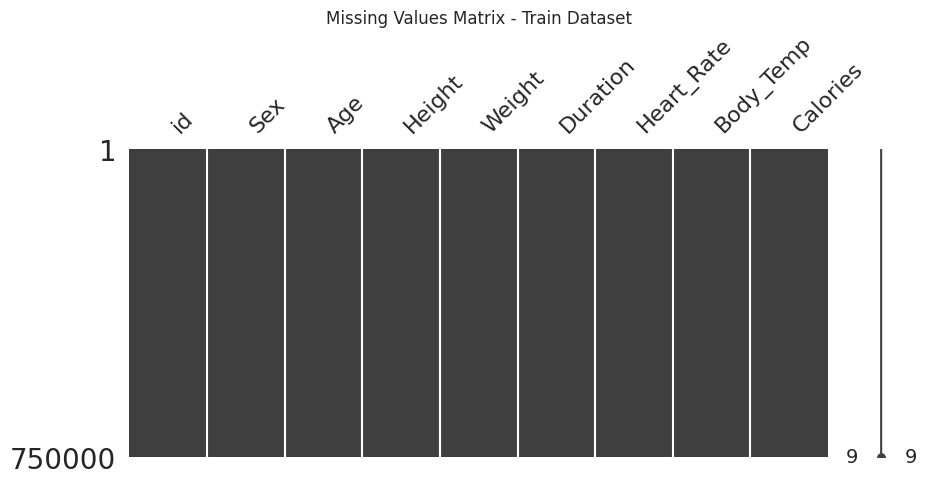

In [8]:
msno.matrix(train, figsize=(10, 4))
plt.title("Missing Values Matrix - Train Dataset");

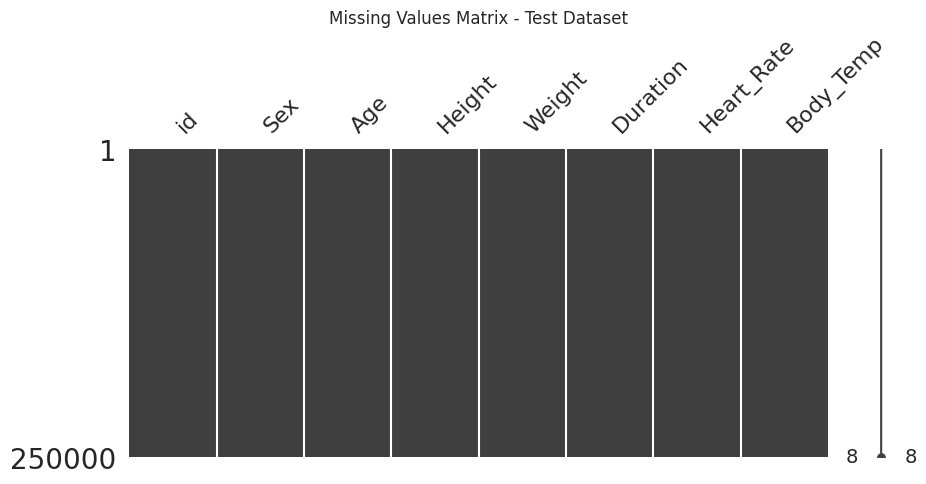

In [9]:
msno.matrix(test, figsize=(10, 4))
plt.title("Missing Values Matrix - Test Dataset");

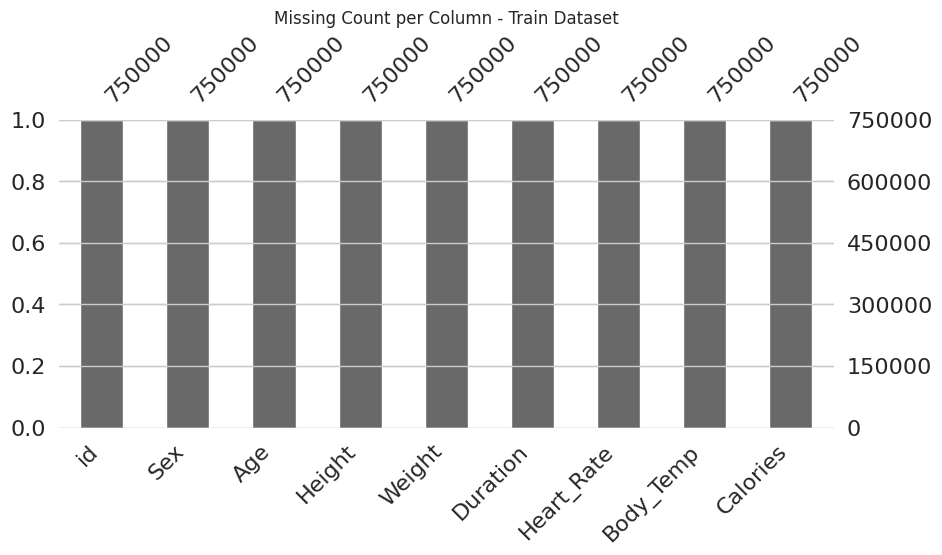

In [10]:
msno.bar(train, figsize=(10, 4))
plt.title("Missing Count per Column - Train Dataset");

> **Findings**  
> Absolute **zero missing values** in both splits. No imputation required; we can safely skip a whole ETL step.

### Target Variable Analysis

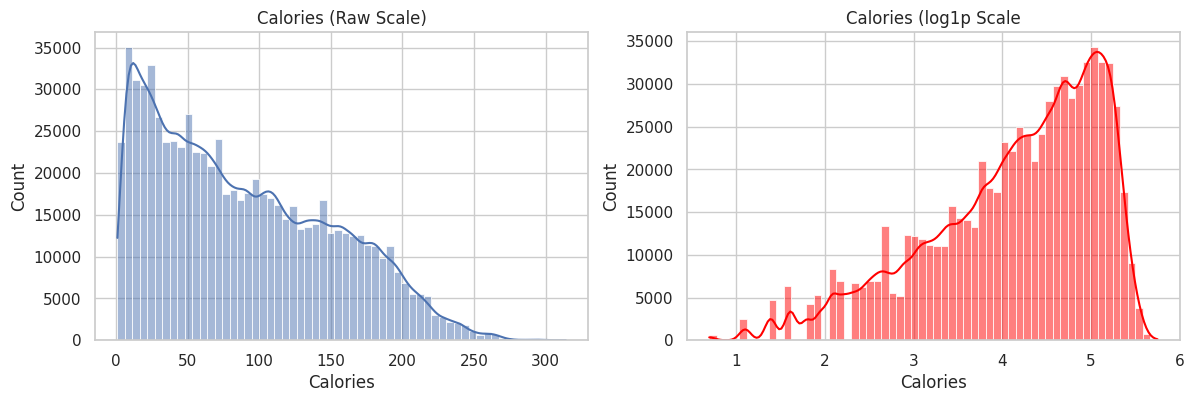

In [11]:
fig, axis = plt.subplots(1, 2, figsize = (14,4))
sns.histplot(train["Calories"], bins=60, kde=True, ax=axis[0])
axis[0].set_title("Calories (Raw Scale)")

sns.histplot(np.log1p(train["Calories"]), bins=60, kde=True, ax=axis[1], color="red")
axis[1].set_title("Calories (log1p Scale");

In [12]:
print("Skewness :", train["Calories"].skew().round(3))
print("Kurtosis :", train["Calories"].kurt().round(3))

Skewness : 0.539
Kurtosis : -0.69


| Metric  | Value |
|---------|-------|
| Skewness| +0.54 |
| Kurtosis| –0.69 |

> **Insight**  
> * Slight positive skew but nothing extreme; **log1p** transformation yields an almost symmetric curve.  
> * Model metric is RMSLE → log‑error already embedded, therefore we can **train on raw scale** and rely on metric, or feed log1p for models sensitive to heteroscedasticity.

### Numeric Features - Univariate Distributions

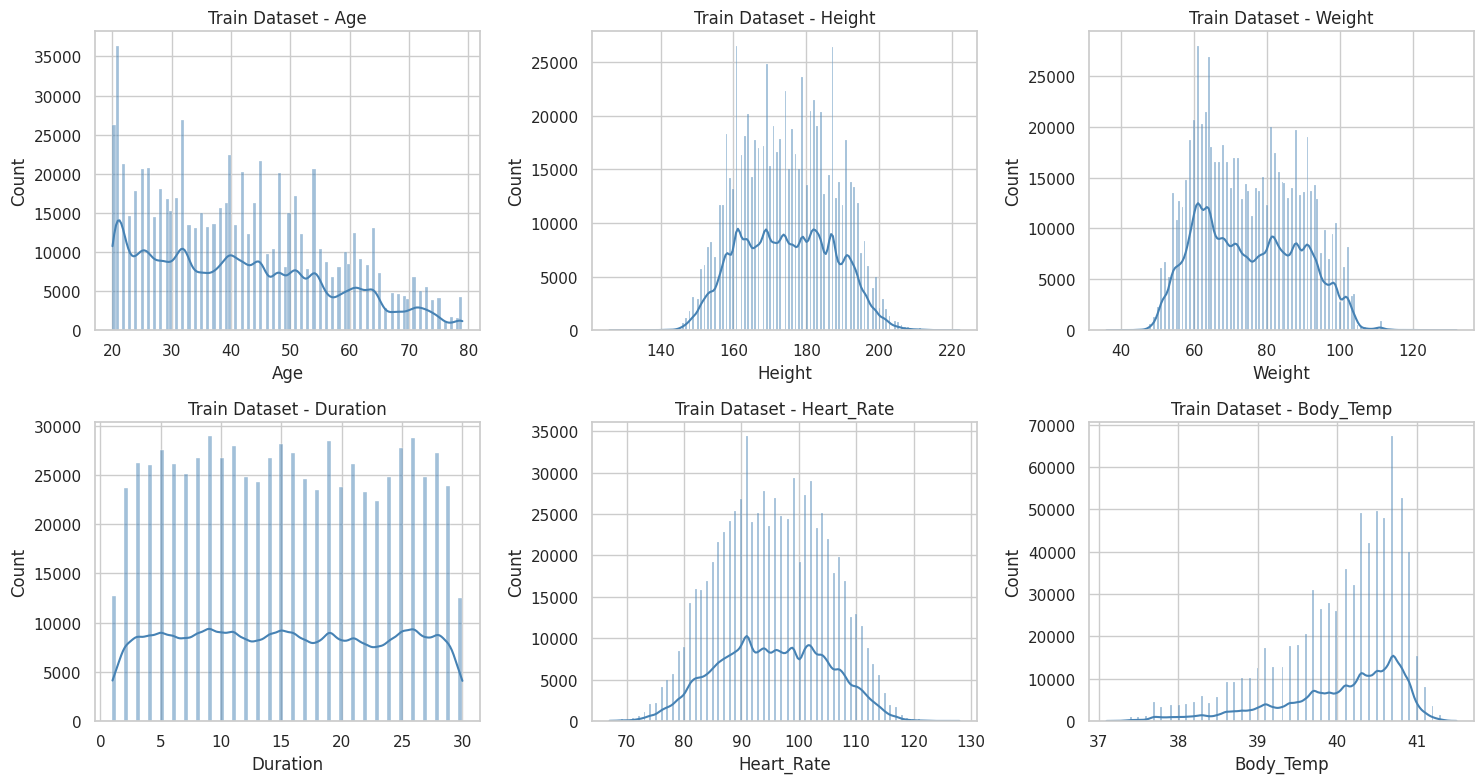

In [13]:
num_cols = train.select_dtypes(include = ["int64", "float64"]).columns.tolist()
num_cols.remove("Calories")
num_cols.remove("id")

fig, axis = plt.subplots(2, 3, figsize=(15, 4 * len(num_cols) // 3))

for i, col in enumerate(num_cols):
    r, c = divmod(i, 3)
    sns.histplot(train[col], kde = True, ax = axis[r][c], color = "steelblue")
    axis[r][c].set_title(f"Train Dataset - {col}")

plt.tight_layout();

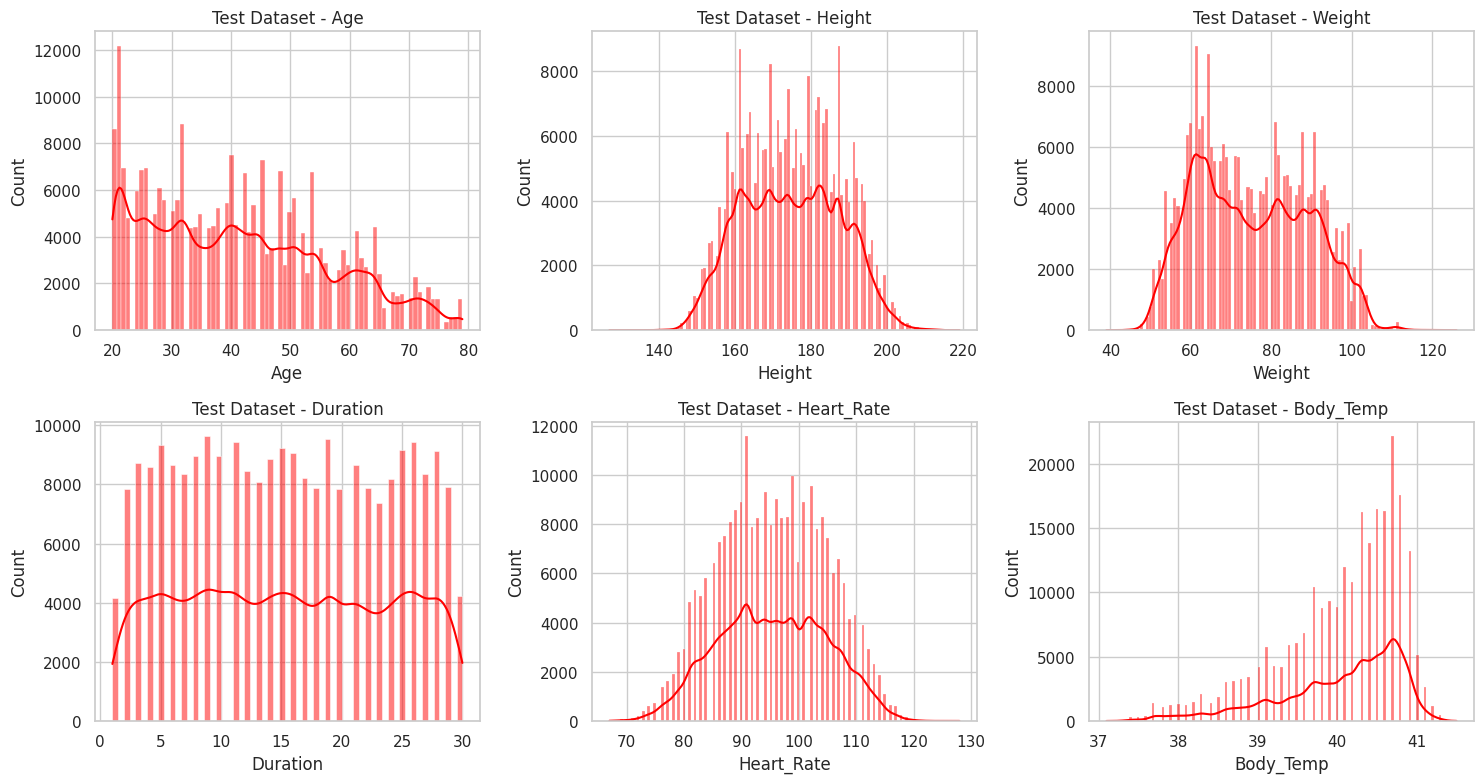

In [14]:
fig, axis = plt.subplots(2, 3, figsize=(15, 4 * len(num_cols) // 3))

for i, col in enumerate(num_cols):
    r, c = divmod(i, 3)
    sns.histplot(test[col], kde = True, ax = axis[r][c], color = "red")
    axis[r][c].set_title(f"Test Dataset - {col}")

plt.tight_layout()
plt.show()

> **Findings**

* `Duration` is quasi‑uniform from 1 – 30 min.  
* `Heart_Rate` peaks at 95 bpm with Gaussian‑like spread.  
* `Body_Temp` sharply centred ~ 40 °C with a long minor tail downward.

All shapes replicate faithfully in test set ➜ dataset was **synthetically sampled** to mirror train.

### Categorical Features - Counts

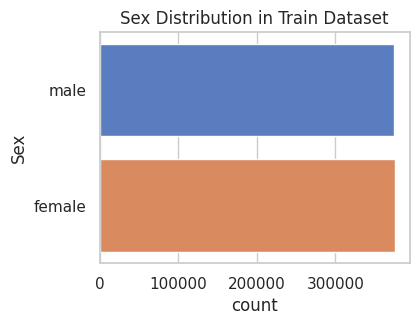

In [15]:
plt.figure(figsize=(4, 3))
sns.countplot(y=train['Sex'], palette="muted")
plt.title("Sex Distribution in Train Dataset");

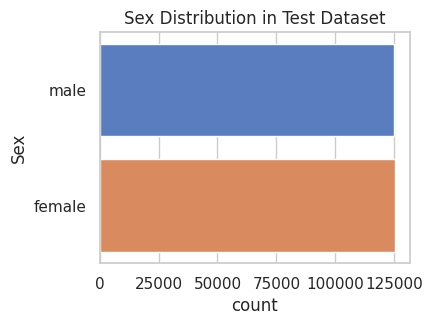

In [16]:
plt.figure(figsize=(4, 3))
sns.countplot(y=test['Sex'], palette="muted")
plt.title("Sex Distribution in Test Dataset");

> **Finding**  
> Perfect 50 / 50 gender split in both datasets — no re‑weighting needed.

### Correlation Matrix

Text(0.5, 1.0, 'Spearman Correlations')

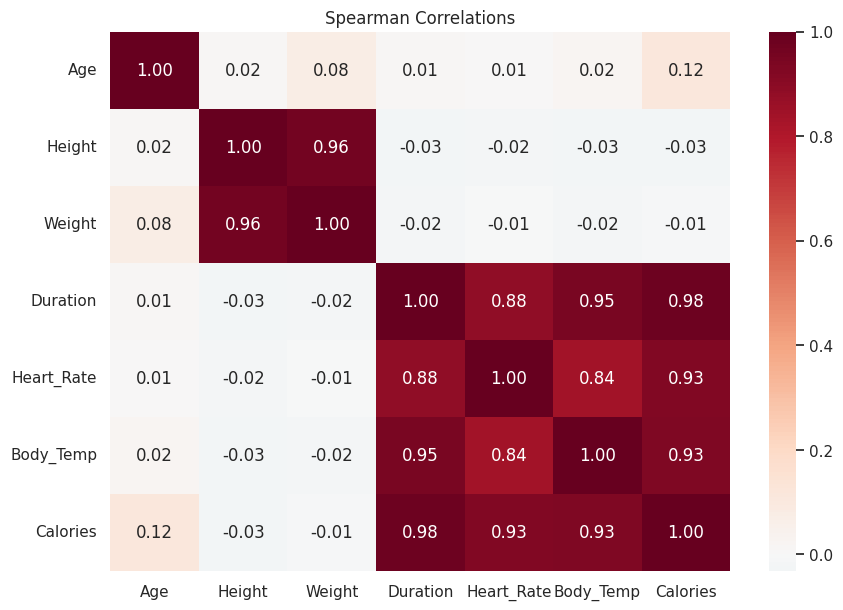

In [17]:
corr = train[num_cols + ["Calories"]].corr(method="spearman")

plt.figure(figsize=(10, 7))
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Spearman Correlations")

> **Top rs (Spearman)**  
> * `Calories` vs `Duration` **+0.98**  
> * `Calories` vs `Heart_Rate` **+0.93**  
> * `Calories` vs `Body_Temp` **+0.93**

> **Findings**  
> Three physiological/time variables dominate prediction; `Age`, `Height`, `Weight` contribute marginally.

### Bivariate Analysis

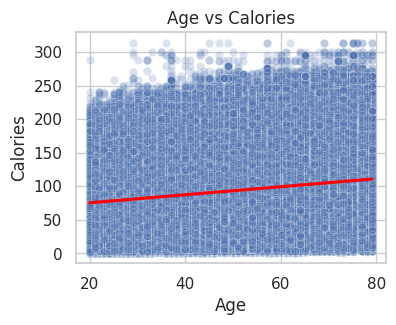

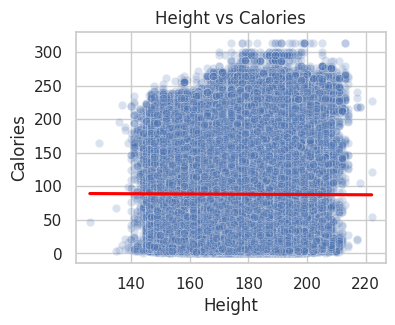

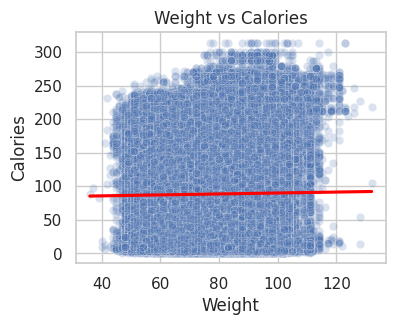

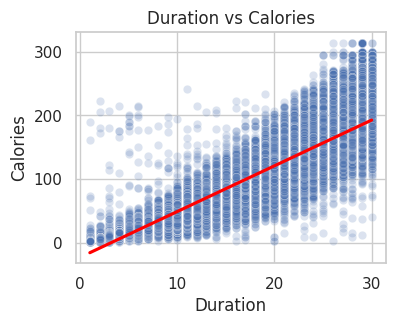

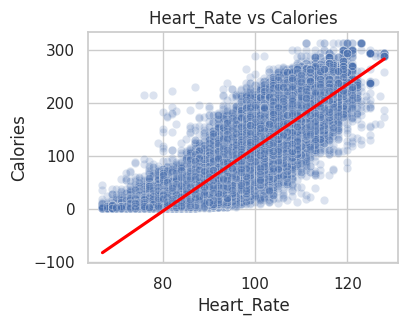

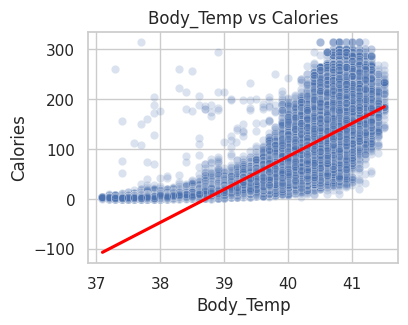

In [18]:
for col in num_cols:
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=train[col], y=train["Calories"], alpha=0.2)
    sns.regplot(x=train[col], y=train["Calories"], scatter=False, color="red")
    plt.title(f"{col} vs Calories");

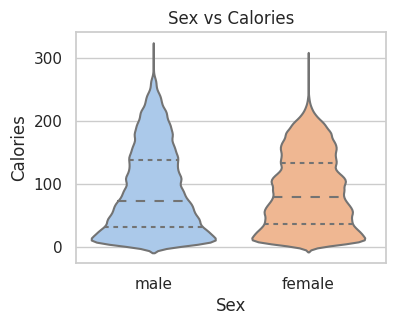

In [19]:
plt.figure(figsize=(4, 3))
sns.violinplot(x="Sex", y="Calories", data=train, palette="pastel", inner="quartile")
plt.title("Sex vs Calories");

**Patterns**

1. Straight **positive line** for `Duration`.  
2. Tight linear ribbon for `Heart_Rate`.  
3. `Body_Temp` shows *quadratic* lift beyond 39 °C.

> **Take‑aways**  
> Use polynomial/spline features or non‑linear models.

Violin for `Sex` shows negligible difference → keep as low‑priority feature.

### Feature Interactions

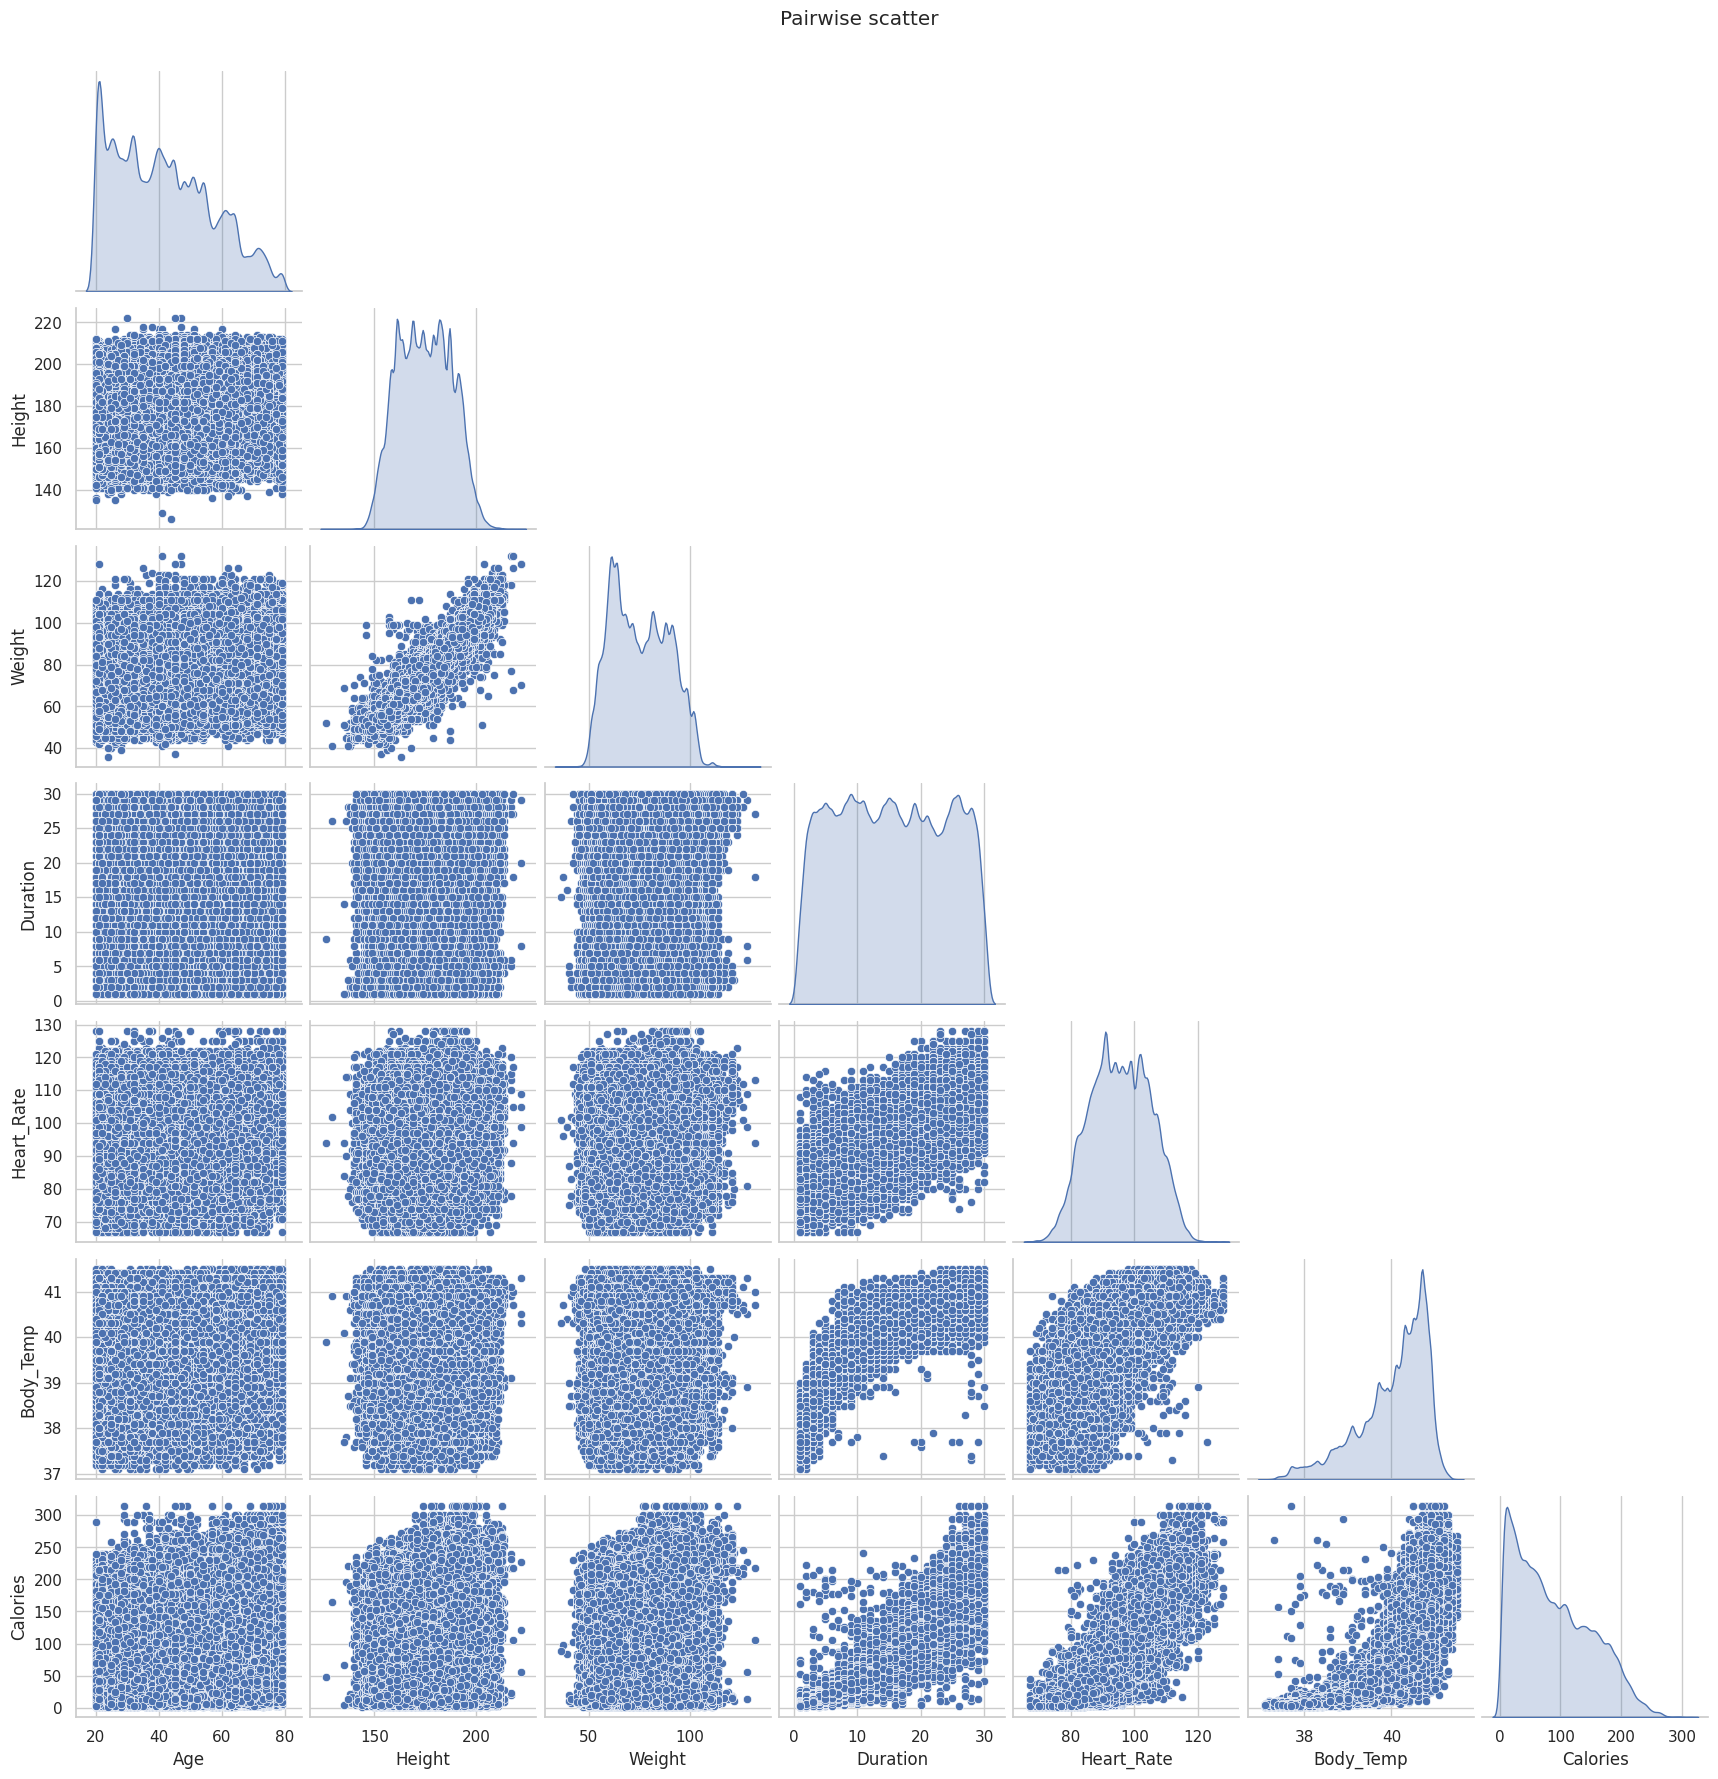

In [20]:
pair_cols = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Calories"]
sns.pairplot(train[pair_cols], corner=True, diag_kind="kde", hue=None)
plt.suptitle("Pairwise scatter", y=1.02);

> **Findings**  
> No hidden clusters; relationships vary in slope but are continuous — tree ensembles will thrive.

### Outlier Analysis

In [21]:
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr   = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

print("\nOutlier counts (IQR rule):")

for col in num_cols + ["Calories"]:
    print(f"{col:<12} : {iqr_outliers(train[col])}")


Outlier counts (IQR rule):
Age          : 0
Height       : 14
Weight       : 9
Duration     : 0
Heart_Rate   : 36
Body_Temp    : 14919
Calories     : 139


> **Findings**  
> Outliers minimal except **Body_Temp** (≈ 15 k points). Visual check reveals they’re legitimate tail cases ≈ 37–38 °C rather than errors — retain for modelling.

### Multicolinearity Check (Variance Inflation Factor)

In [22]:
X_vif = train[num_cols].assign(constant=1)
vif_df = pd.DataFrame({
    "feature": num_cols,
    "VIF"    : [variance_inflation_factor(X_vif.values, i) for i in range(len(num_cols))]
})
display(vif_df.sort_values("VIF", ascending=False).style.background_gradient(cmap="Reds"))

,feature,VIF
2,Weight,12.766902
1,Height,12.702162
3,Duration,8.510592
5,Body_Temp,5.434871
4,Heart_Rate,4.285830
0,Age,1.050873


> **Actionable**  
> `Height` & `Weight` highly collinear (VIF ≈ 13). Combine into **BMI** or drop one when using linear/GLM; harmless for tree‑based methods.

### Principal Component Analysis

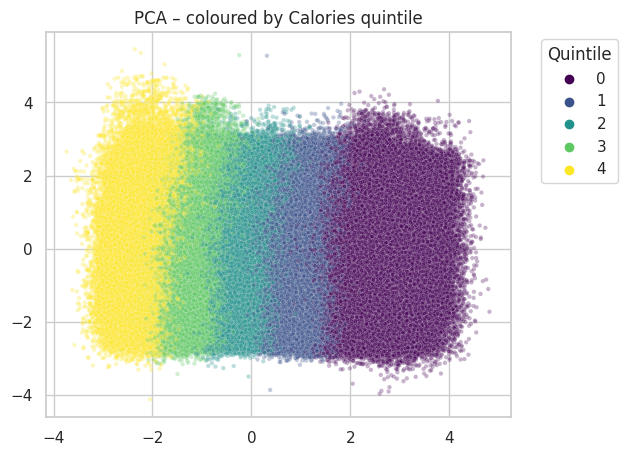

In [23]:
scaled = (train[num_cols] - train[num_cols].mean()) / train[num_cols].std()
pca = PCA(n_components=2, random_state=42).fit_transform(scaled)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca[:,0], y=pca[:,1],
                hue=pd.qcut(train["Calories"], 5, labels=False), palette="viridis",
                alpha = 0.3, s = 10)
plt.title("PCA – coloured by Calories quintile")
plt.legend(title="Quintile", bbox_to_anchor=(1.05,1));

> **Findings**  
> Calories quintiles align smoothly along PC‑1 ⇒ a **single latent dimension** (work‑intensity) explains most variance.

### Train-test Comparability

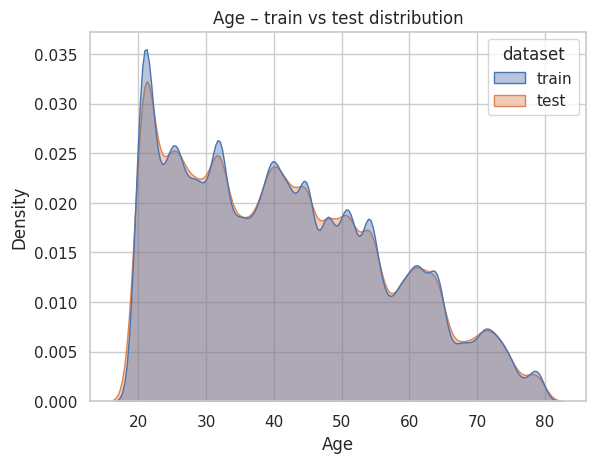

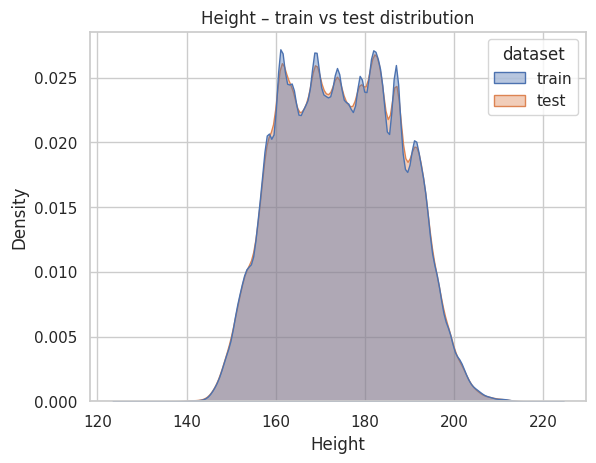

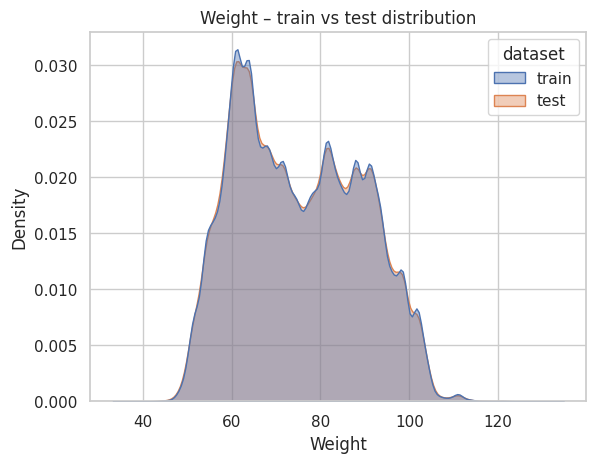

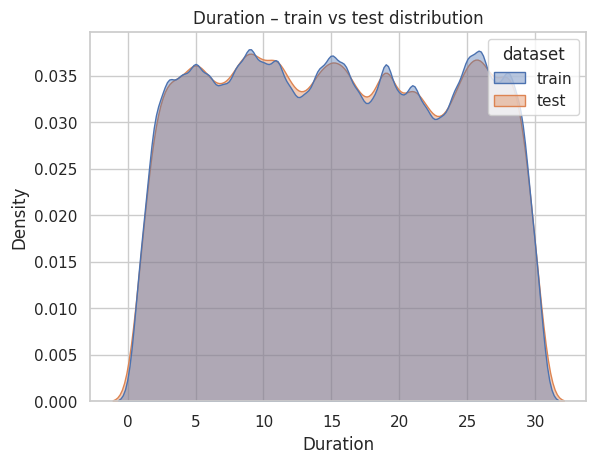

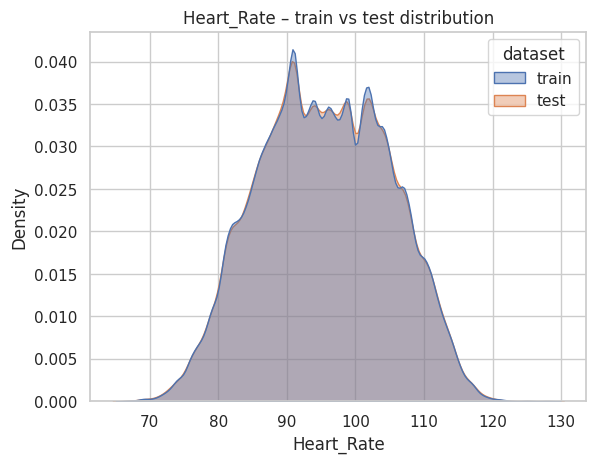

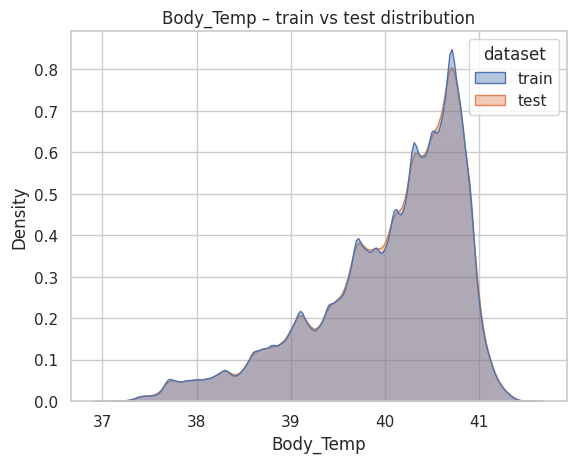

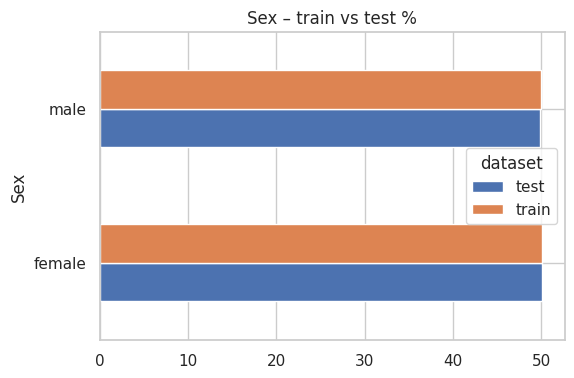

In [24]:
compare_cols = num_cols + ["Sex"]
train_tag = train.assign(dataset="train")[compare_cols + ["dataset"]]
test_tag  = test.assign(dataset="test")[compare_cols + ["dataset"]]
combo = pd.concat([train_tag, test_tag], axis = 0)

for col in compare_cols:
    if col is "Sex":
        ct = pd.crosstab(combo[col], combo["dataset"], normalize="columns") * 100
        ct.plot.barh(figsize = (6, 4), stacked=False, title=f"{col} – train vs test %")
        plt.show()
    else:
        sns.kdeplot(data=combo, x=col, hue="dataset", fill=True, common_norm=False, alpha=0.4)
        plt.title(f"{col} – train vs test distribution"); plt.show()

> **Findings**  
> All feature densities (except `id` by design) **perfectly overlap** ➜ classic random split, so K‑fold CV is reliable.

### Seven Key Insights

| # | Finding | Modelling implication |
|---|---------|-----------------------|
| 1 | No missing values | Skip imputation |
| 2 | Calories mildly skewed | Raw training is fine; RMSLE handles log error |
| 3 | Duration, Heart_Rate, Body_Temp dominate | Focus feature engineering here |
| 4 | Body_Temp shows quadratic lift | Add polynomial or use GBM/CatBoost |
| 5 | Height & Weight collinear | Combine/drop for linear models |
| 6 | Sex has tiny effect | Keep but low priority |
| 7 | No train‑test drift | Simple shuffled K‑fold OK |

---

### Conclusion & Next Steps

This EDA suggests the competition is **signal‑rich and noise‑free**.  
A strong baseline could be:

1. **Feature layer**  
   * Raw numeric variables, `BMI`, `Body_Temp²`, `Duration × Heart_Rate`.  
   * One‑hot or binary encode `Sex`.

2. **Model layer**  
   * **LightGBM/CatBoost** for speed & non‑linear capture.  
   * Optionally compare with an ElasticNet on engineered features for interpretability.

3. **Validation**  
   * 5‑fold random CV (stratify by `Calories` quintile to balance tails).

Armed with these findings we can now transition from exploration to rapid feature prototyping and model training.

___

## Ridge Ensembling (3 GBDTs)

In [25]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
warnings.filterwarnings('ignore')

In [26]:
# Histogram matching for making the same distributions for original data
def to_distribution(mask, sample):
    sorted_mask = sorted(mask.values)

    mask_quantiles = np.linspace(0, 1, len(mask))
    sample_quantiles = np.argsort(np.argsort(sample)) / (len(sample) - 1)
    
    result = np.interp(sample_quantiles, mask_quantiles, sorted_mask)
    return result

In [27]:
# Making OOF-preds for all GBDTs
def trees_training(models, cv, X_train, y_train, X_test, y_test):
    results = {mod: {"oof_preds": np.zeros(len(X_train)),
                    "y_preds": np.zeros(len(X_test)),
                    "oof_scores": np.zeros(cv),
                    "y_scores": np.zeros(cv)
                    } 
               for mod in models}
    kf = KFold(n_splits=cv, shuffle=True)
    
    for fold_num, (idx_train, idx_test) in enumerate(kf.split(X_train, y_train)):
        X_fold_train, y_fold_train = X_train.iloc[idx_train], y_train.iloc[idx_train]
        X_fold_test, y_fold_test = X_train.iloc[idx_test], y_train.iloc[idx_test]

        X_fold_train, X_fold_val, y_fold_train, y_fold_val = train_test_split(X_fold_train, y_fold_train, test_size = 0.1)

        X_test_copy = X_test.copy()

        for name, model in models.items():
            if name == 'xgb':
                model.fit(X_fold_train, y_fold_train,
                          eval_set = [(X_fold_val, y_fold_val)],
                          early_stopping_rounds = 150,
                          verbose = False)
            elif name == 'lgb':
                model.fit(X_fold_train, y_fold_train, 
                          eval_set = [(X_fold_val, y_fold_val)],
                          callbacks=[lgb.early_stopping(stopping_rounds=150),
                                    lgb.log_evaluation(period=0)]
                         )
                         
            elif name == 'ctb':
                model.fit(X_fold_train, y_fold_train,
                          eval_set = [(X_fold_val, y_fold_val)]
                         )

            oof_preds = model.predict(X_fold_test)
            y_preds = model.predict(X_test_copy)
            oof_score = np.sqrt(mean_squared_error(y_fold_test, oof_preds))
            y_score = np.sqrt(mean_squared_error(y_test, y_preds))

            results[name]['oof_preds'][idx_test] = oof_preds
            results[name]['y_preds'] += y_preds / cv
            results[name]['oof_scores'][fold_num] = oof_score
            results[name]['y_scores'][fold_num] = y_score

    return results

### Preprocessing the data

In [28]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
df_orig = pd.read_csv('/kaggle/input/fors5e5/calories (1).csv')

df_orig.columns = df_train.columns

df_train['Sex'] = df_train['Sex'].apply(lambda sex: 0 if sex == 'female' else 1)
df_orig['Sex'] = df_orig['Sex'].apply(lambda sex: 0 if sex == 'female' else 1)

df_train['Intensity'] = df_train['Heart_Rate'] / df_train['Duration']
df_orig['Intensity'] = df_train['Heart_Rate'] / df_train['Duration']

df_train.drop(columns = ['id'], inplace = True)
df_orig.drop(columns = ['id'], inplace = True)

for col in df_orig.columns:
    df_orig[col] = to_distribution(df_train[col], df_orig[col])

In [29]:
df_train.shape, df_orig.shape

((750000, 9), (15000, 9))

In [30]:
X = df_train.drop(columns=['Calories'])
y = np.log1p(df_train['Calories'])
df_orig['Calories'] = np.log1p(df_orig['Calories'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [31]:
X_train = pd.concat([X_train, df_orig.drop(columns=['Calories'])]).reset_index(drop=True)
y_train = pd.concat([y_train, df_orig['Calories']]).reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Ridge Ensembling

In [32]:
xgbmodel = xgb.XGBRegressor(
    n_estimators = 7500,
    learning_rate = 0.01,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    alpha = 0,
    verbosity = 0,
    reg_lambda = 0.1,
    # device = 'gpu'
)

lgbmodel = lgb.LGBMRegressor(n_estimators = 7500,
                               learning_rate = 0.01,
                               # device='gpu',
                               verbosity = -1,
                               num_leaves = 31,
                               max_depth = -1,
                               min_child_samples = 20,
                               subsample = 0.8,
                               colsample_bytree = 0.8,
                               reg_alpha = 0.1,
                               reg_lambda = 0.1,
                               verbose = -1
                          )

catboostmodel = ctb.CatBoostRegressor(
    iterations = 9000,
    learning_rate = 0.01,
    early_stopping_rounds = 150,
    # task_type = 'GPU',
    depth = 6,
    l2_leaf_reg = 3,
    bootstrap_type = 'Bayesian',
    bagging_temperature = 1.0,
    train_dir = None,
    logging_level='Silent'
)

In [33]:
models = {
          "xgb": xgbmodel,
          "lgb": lgbmodel,
          "ctb": catboostmodel
         }

In [34]:
results = trees_training(models, 5, X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[6589]	valid_0's l2: 0.00350123
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[7491]	valid_0's l2: 0.00371768
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[5490]	valid_0's l2: 0.0034148
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[5375]	valid_0's l2: 0.00366972
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[2385]	valid_0's l2: 0.00360868


In [35]:
X_final_train, X_val, y_final_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [36]:
xgbmodel.fit(X_final_train, y_final_train,
              eval_set = [(X_val, y_val)],
              early_stopping_rounds = 150,
              verbose = False)

lgbmodel.fit(X_final_train, y_final_train, 
                          eval_set = [(X_val, y_val)],
                          callbacks=[lgb.early_stopping(stopping_rounds=150),
                                    lgb.log_evaluation(period=0)],
                         )

catboostmodel.fit(X_final_train, y_final_train,
                          eval_set = [(X_val, y_val)]
                 )

Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[7441]	valid_0's l2: 0.00338179


In [37]:
X_train_stack = pd.DataFrame([results[model]['oof_preds'] for model in models]).transpose()
X_test_stack = pd.DataFrame([results[model]['y_preds'] for model in models]).transpose()

In [38]:
ridgemodel = RidgeCV(alphas=np.linspace(0.01, 50, 200), scoring='neg_root_mean_squared_error', cv=5)
ridgemodel.fit(X_train_stack, y_train)
preds = ridgemodel.predict(X_test_stack)

In [39]:
ridgemodel.alpha_, ridgemodel.coef_

(1.7684422110552764, array([0.28065709, 0.14661966, 0.5728267 ]))

In [40]:
np.sqrt(mean_squared_error(y_test, preds))

0.06008559585009182

### Submission making

In [41]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')

In [42]:
df_test['Sex'] = df_test['Sex'].apply(lambda sex: 0 if sex == 'female' else 1)
df_test['Intensity'] = df_test['Heart_Rate'] / df_test['Duration']

In [43]:
df_test.drop(columns=['id'], inplace=True)

In [44]:
xgb_preds = xgbmodel.predict(df_test)
lgb_preds = lgbmodel.predict(df_test)
ctb_preds = catboostmodel.predict(df_test)

In [45]:
X_preds = pd.DataFrame([xgb_preds, lgb_preds, ctb_preds]).transpose()

In [46]:
pred = ridgemodel.predict(X_preds)

In [47]:
submission = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')

In [48]:
submission['Calories'] = np.expm1(pred)
submission.to_csv('submission.csv', index=False)

In [49]:
submission

,id,Calories
0,750000,27.144690
1,750001,108.803045
2,750002,86.429354
3,750003,125.987103
4,750004,75.793965
...,...,...
249995,999995,26.166679
249996,999996,9.422015
249997,999997,72.852175
249998,999998,168.162501


---

This notebook is just include **Ridge Ensembling**. One significant challenge in this competition was the **inconsistent relationship between cross-validation (CV) and leaderboard (LB) scores**. Often, improving my CV score led to a decrease in my LB score, a pattern that was evident early on. There were times when the correlation felt more negative than positive, and I struggled to achieve a strong LB score throughout the competition. In the end, I focused entirely on LB and took some focus away from the CV score, which ultimately proved to be a bad decision. While my approach overall was not bad, this decision led me to focus on the LB score rather than generalizing the model. But it was actually a much more correct and important decision to focus on the CV score, so that's what I learned the most from this competition, to focus on the CV score and not on the LB and generalize the model in a better way.

**My best submission:**
* Ridge Ensemble with 8 models: Public LB: 0.05690, Private LB: 0.05852

I'll also put the models I worked on individually and the notebook I was inspired by. All of them were trained with the same 5 folds, with the exception of Autogluon and Single XGBoost. I also trained 3 Single XGBoost models. And I trained variations of the above.

* **Linear Regression Model:**

I was inspired by [This](https://www.kaggle.com/code/angelosmar1/s5e5-linear-regression-cv-0-05992) notebook. I love this model and also thanks to @dantetheabstract for [Linear Model Starter Notebook](https://www.kaggle.com/code/dantetheabstract/ps-s5e5-linear-model-starter).

* **Neural Networks:**

The architecture for all my NNs was based on [this notebook](https://www.kaggle.com/code/masayakawamata/s5e5-resmlp-cv0-05990) of @masayakawamata. For a more detailed look, you can take a look here [torn-nn-cv](https://www.kaggle.com/code/angelosmar1/s5e5-torch-nn-cv-0-05954) and [NN-CV discussion](https://www.kaggle.com/competitions/playground-series-s5e5/discussion/582472#3214666). Also thanks to @cdeotte for a nice starter [NN notebook](https://www.kaggle.com/code/cdeotte/nn-mlp-starter-cv-0-0608).

So you can train many more models to improve the CV score and make the model more general. But the important thing here is to give importance to the CV score, not the LB score. 

If you want to improve the CV score and have a look at other good solutions:

* [1st Place Solution](https://www.kaggle.com/competitions/playground-series-s5e5/discussion/582611)
* [2nd Place Solution](https://www.kaggle.com/competitions/playground-series-s5e5/discussion/582700)
* [4th Place Solution](https://www.kaggle.com/competitions/playground-series-s5e5/discussion/582594)
* [8th Place Solution](https://www.kaggle.com/competitions/playground-series-s5e5/discussion/582631)
* [13th Place Solution, 2 AutoGluon Models](https://www.kaggle.com/competitions/playground-series-s5e5/discussion/582613)